In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# dimensionality reduction: 2D plane
latent_dim = 2

### Encoder

In [4]:
def encoder():
    """        
    Makes and returns an encoder model ofr VAE.
    input Image shape: (64, 64, 3).ipynb_checkpoints
    Outputs: Mean & Log variance of the latent space distribution.

    Returns:
        keras.Model: An encoder model that takes input images and outputs the mean
                and log variance of the latent space distribution.
    """
    encoder_inputs = keras.Input(shape=(64,64,3))
    x = layers.Conv2D(16,3,activation = "relu",strides = 2, padding="same")(encoder_inputs)
    x = layers.Conv2D(32,3,activation = "relu",strides = 2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(8,activation="relu")(x)
    z_mean = layers.Dense(latent_dim,name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim,name="z_log_var")(x)
    encoder = keras.Model(encoder_inputs,[z_mean,z_log_var], name="encoder")

    return encoder


In [5]:
encoder = encoder()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   4640        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['conv2d_1[0][0]']               
                                                                                            

### Sampling Layer:

In [6]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        """    
        Generate samples from a Gaussain distribution using the reparameterization trick.
        Args:
            1. z_mean
            2. log_var
        Returns:
            f.Tensor: Samples drawn from the Gaussian distribution in the latent space.
        """
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Drawing a batch of normal random vectors:
        epsilon = tf.random.normal(shape=(batch_size,z_size))
        # VAE sampling formula:
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Decoder:

In [7]:
def decoder():
    """    
    Makes the decoder model for the VAE.
    Parameters are set according to the structure of encoder model.
    Returns:
        keras.Model: The decoder Model

    """
    # Input where z will be fed: z --> latent point (vecotr)
    latent_inputs = keras.Input(shape=(latent_dim,))
    # To produce the same number of co-efficients that we had at the level of the flatten layer in the encoder:
    x = layers.Dense(16 * 16 * 32, activation="relu")(latent_inputs)
    # Reverting the flatten layer:
    x = layers.Reshape((16, 16, 32))(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding = "same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder

In [8]:
decoder = decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 8192)              24576     
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 32)       9248      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         435 

### VAE Model:

In [9]:
dataset = keras.utils.image_dataset_from_directory(
    "../celeb_data/data/",
    label_mode=None,
    image_size=(64,64),
    batch_size=1,
    smart_resize=True
)

Found 4920 files belonging to 1 classes.


In [10]:
# scaling the images from 0 to 1:
dataset = dataset.map(lambda x: x/255.)

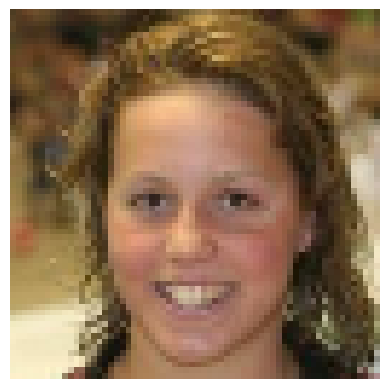

In [11]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy()*255).astype("int32")[0])
    break

In [12]:
# verifying the input shape of images:
for image_batch in dataset.take(5):
    print(image_batch.shape)

(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)


## Testing the individual functionality of code blocks:

In [13]:
z_mean, z_log_var = encoder.predict(dataset.take(1))

1/1 [==============================] - 0s 115ms/step


In [14]:
latent_vector  = Sampler().call(z_mean,z_log_var)

In [15]:
reconstructed_image = decoder.predict(latent_vector)

1/1 [==============================] - 0s 70ms/step


In [16]:
print(f'{z_mean}')
print(f'{z_log_var}')
print(f"{latent_vector}")

[[-0.00514941  0.01296223]]
[[ 0.07785428 -0.0708928 ]]
[[0.69287926 0.6741134 ]]


In [17]:
# Defining a custom keras model called VAE:
class VAE(keras.Model):

    """
    Variational Autoencoder (VAE) model.

    This model combines an encoder, decoder, and sampler to perform variational autoencoding.

    Args:
        encoder (keras.Model): The encoder model responsible for encoding input data.
        decoder (keras.Model): The decoder model responsible for decoding latent representations.
        **kwargs: Additional keyword arguments to pass to the parent class.

    Attributes:
        encoder (keras.Model): The encoder model.
        decoder (keras.Model): The decoder model.
        sampler (Sampler): An instance of the Sampler class for sampling latent representations.
        total_loss_tracker (keras.metrics.Mean): Metric to track the total loss during training.
        reconstruction_loss_tracker (keras.metrics.Mean): Metric to track the reconstruction loss during training.
        kl_loss_tracker (keras.metrics.Mean): Metric to track the KL divergence loss during training.
    """
    def __init__(self, encoder, decoder, **kwargs):
        """
        Initialize the VAE model.

        Args:
            encoder (keras.Model): The encoder model.
            decoder (keras.Model): The decoder model.
            **kwargs: Additional keyword arguments to pass to the parent class.
        """
        # calling the constructor of the parent class:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    # @property a decorator in python used for defining properties of class , truns functions to attributes:
    @property
    # custom metrics:
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    # A single training step is defined for the VAE model:
    def train_step(self,data):
        """
        Perform a single training step for the VAE model.

        Args:
            data: Input data for training.

        Returns:
            dict: Dictionary containing the updated loss metrics.
        """
        with tf.GradientTape() as tape:
            z_mean, z_log_var =self.encoder(data)
            z = self.sampler(z_mean,z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
# this line learns the KL divergence loss:
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # total loss which is the sum of kl loss and reconstruction loss:
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
# This line computes the gradients of the total loss with respect to the the trainable weights of the model:
            grads = tape.gradient(total_loss, self.trainable_weights)
            # This line applies the the gradients to update the model's weight using the specified optimizer, when compiling the model:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
#  The following lines update teh state of the loss trackers with the computerd loss
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)

            return {
                "total_loss" : self.total_loss_tracker.result(),
                "reconstruction_loss" : self.reconstruction_loss_tracker.result(),
                "kl_loss" : self.kl_loss_tracker.result()
            }

### Training VAE:

In [18]:
vae = VAE(encoder=encoder, decoder=decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

In [20]:
history = vae.fit(dataset, epochs=30, batch_size=100)

Epoch 1/30


4920/4920 [==============================] - 126s 26ms/step - total_loss: 2525.7590 - reconstruction_loss: 2519.4163 - kl_loss: 6.3466
Epoch 2/30
4920/4920 [==============================] - 182s 37ms/step - total_loss: 2490.7043 - reconstruction_loss: 2486.5110 - kl_loss: 4.1939
Epoch 3/30
4920/4920 [==============================] - 195s 40ms/step - total_loss: 2485.3977 - reconstruction_loss: 2482.0081 - kl_loss: 3.3888
Epoch 4/30
4920/4920 [==============================] - 243s 49ms/step - total_loss: 2465.0371 - reconstruction_loss: 2461.5017 - kl_loss: 3.5300
Epoch 5/30
4920/4920 [==============================] - 226s 46ms/step - total_loss: 2424.9463 - reconstruction_loss: 2420.6609 - kl_loss: 4.2856
Epoch 6/30
4920/4920 [==============================] - 239s 49ms/step - total_loss: 2422.2429 - reconstruction_loss: 2418.0698 - kl_loss: 4.1704
Epoch 7/30
4920/4920 [==============================] - 226s 46ms/step - total_loss: 2420.3259 - reconstruction_loss: 2416.3279 - kl_lo

### Sampling a grid of images:

In [21]:
history.history.keys()

dict_keys(['total_loss', 'reconstruction_loss', 'kl_loss'])

In [24]:
total_loss = history.history["total_loss"]
reconstruction_loss = history.history["reconstruction_loss"]
kl_loss = history.history["kl_loss"]

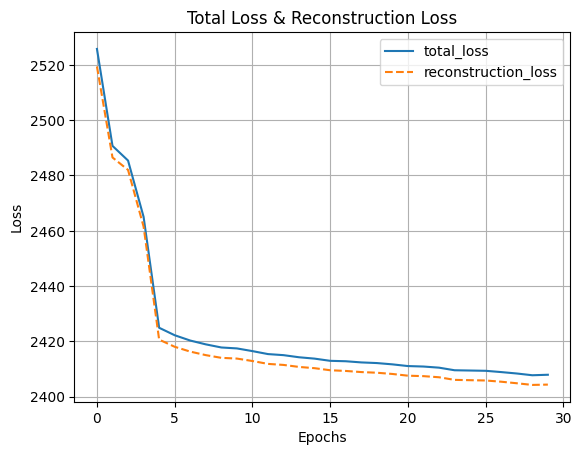

In [30]:
plt.plot(total_loss, label = "total_loss")
plt.plot(reconstruction_loss, ls="--", label = "reconstruction_loss")
plt.title("Total Loss & Reconstruction Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show();

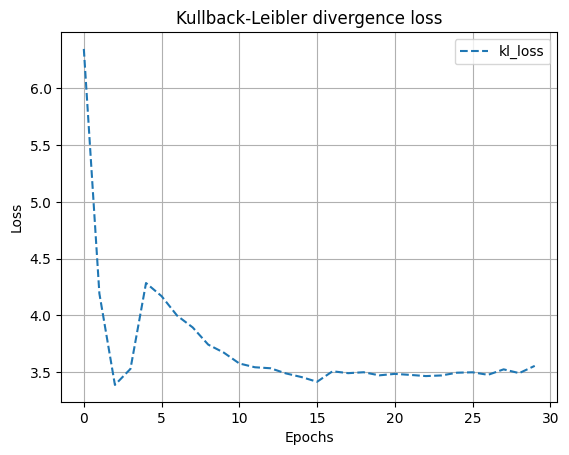

In [31]:
plt.plot(kl_loss, ls="--", label = "kl_loss")
plt.title("Kullback-Leibler divergence loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show();

In [60]:
z_sample = np.array([[1.,0.5]])
img = vae.decoder.predict(z_sample)
img = img.reshape((64,64,3))

1/1 [==============================] - 0s 16ms/step


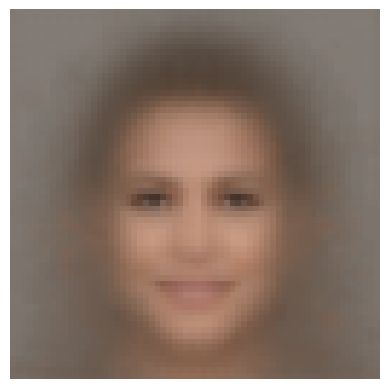

In [61]:
plt.imshow(img)
plt.axis("off")
plt.show();